In [79]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_csv_files(folder_path):
  cleaned_dataframes = {}

  # List of additional columns to drop
  columns_to_drop = [
      "status", "start_date", "end_date", "window_start_date", "window_end_date",
      "emails", "devs", "emails_thread_starter", "emails_thread_starter_word_count",
      "emails_thread_starter_characters", "emails_threads", "emails_threads_word_count",
      "emails_threads_characters", "emails_no_replies", "emails_no_replies_word_count",
      "emails_no_replies_characters", "emails_jira", "most_complex_unit_loc",
      "most_complex_unit_mcabe_index", "total_number_of_files", "number_of_files_main",
      "lines_of_code_main", "number_of_files_test", "lines_of_code_test",
      "test_vs_main_lines_of_code_percentage", "number_of_files_generated",
      "lines_of_code_generated", "number_of_files_build_and_deployment",
      "lines_of_code_build_and_deployment", "negligible_risk_file_size_count",
      "low_risk_file_size_count", "medium_risk_file_size_count", "high_risk_file_size_count",
      "very_high_risk_file_size_count", "negligible_risk_file_size_loc", "low_risk_file_size_loc",
      "medium_risk_file_size_loc", "high_risk_file_size_loc", "very_high_risk_file_size_loc",
      "number_of_units", "lines_of_code_in_units", "lines_of_code_outside_units",
      "unit_size_negligible_risk_loc", "unit_size_negligible_risk_count", "unit_size_low_risk_loc",
      "unit_size_low_risk_count", "unit_size_medium_risk_loc", "unit_size_medium_risk_count",
      "unit_size_high_risk_loc", "unit_size_high_risk_count", "unit_size_very_high_risk_loc",
      "unit_size_very_high_risk_count", "conditional_complexity_negligible_risk_loc",
      "conditional_complexity_negligible_risk_count", "conditional_complexity_low_risk_loc",
      "conditional_complexity_low_risk_count", "conditional_complexity_medium_risk_loc",
      "conditional_complexity_medium_risk_count", "conditional_complexity_high_risk_loc",
      "conditional_complexity_high_risk_count", "conditional_complexity_very_high_risk_loc",
      "conditional_complexity_very_high_risk_count", "conditional_complexity_high_plus_risk_count",
      "conditional_complexity_high_plus_risk_loc", "number_of_contributors",
      "duplication_number_of_duplicates", "duplication_number_of_files_with_duplicates",
      "duplication_number_of_duplicated_lines", "duplication_percentage", "unit_duplicates_count", "releases"
  ]

  for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
      file_path = os.path.join(folder_path, filename)

      # Load CSV file
      df = pd.read_csv(file_path)

      # Drop specified columns
      df = df.drop(
          columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

      key = os.path.splitext(filename)[0]
      cleaned_dataframes[key] = df

  return cleaned_dataframes

folder_path = "scraper-output"
cleaned_data = clean_csv_files(folder_path)


In [80]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_on_each(cleaned_data):
  feature_importance_list = []

  for key, df in cleaned_data.items():
    # Exclude 'project', 'measurement_month', and 'programming_lang' columns
    features = df.drop(
        columns=['project', 'measurement_month', 'programming_lang'], errors='ignore')

    # Handle missing values - fill or drop NaNs
    features = features.fillna(0)

    # Drop columns with zero variance
    features = features.loc[:, features.var() > 0]

    # Check if there are any numeric features left
    numeric_features = features.select_dtypes(include=[np.number])
    if numeric_features.empty:
      print(
          f"Warning: No numeric features left for PCA in {key}. Skipping PCA.")
      continue

    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numeric_features)

    # Perform PCA
    pca = PCA()
    pca.fit(scaled_features)

    # Collect feature importance
    feature_importance = dict(
        zip(numeric_features.columns, pca.explained_variance_ratio_))
    feature_importance_list.append(feature_importance)

  # Compute average importance across all DataFrames
  avg_feature_importance = {}
  for feature_dict in feature_importance_list:
    for feature, importance in feature_dict.items():
      if feature not in avg_feature_importance:
        avg_feature_importance[feature] = []
      avg_feature_importance[feature].append(importance)

  # Compute final average
  avg_feature_importance = {feature: sum(
      values) / len(values) for feature, values in avg_feature_importance.items()}

  # Rank features by average importance
  ranked_features = sorted(avg_feature_importance.items(),
                           key=lambda x: x[1], reverse=True)

  # Display ranked features
  print("Final Ranked Features by Average Importance:")
  for feature, importance in ranked_features:
    print(f"{feature}: {importance:.4f}")


# Perform PCA on each DataFrame and compute overall importance
perform_pca_on_each(cleaned_data)

Final Ranked Features by Average Importance:
commits: 0.3890
authors: 0.1939
committers: 0.1037
minor_contributors: 0.0650
major_contributors: 0.0525
directories: 0.0422
top_level_dirs: 0.0351
active_days: 0.0281
files_modified: 0.0225
files_added: 0.0185
files_deleted: 0.0149
files_renamed: 0.0120
added_lines: 0.0092
deleted_lines: 0.0070
new_contributors: 0.0054
avg_files_modified_commit: 0.0039
code: 0.0028
blanks: 0.0019
files: 0.0014
comments: 0.0009
lines: 0.0006
stars: 0.0003
forks: 0.0002
open_prs: 0.0002
closed_prs: 0.0001
merged_prs: 0.0000
stale_prs: 0.0000
deploys: 0.0000


In [81]:
status_data = pd.read_csv("project-status.csv")

In [82]:
cleaned_data['age'].columns

Index(['project', 'measurement_month', 'commits', 'authors', 'committers',
       'minor_contributors', 'major_contributors', 'directories',
       'top_level_dirs', 'active_days', 'files_modified', 'files_added',
       'files_deleted', 'files_renamed', 'added_lines', 'deleted_lines',
       'new_contributors', 'avg_files_modified_commit', 'code', 'blanks',
       'files', 'comments', 'lines', 'programming_lang', 'stars', 'forks',
       'open_prs', 'closed_prs', 'merged_prs', 'stale_prs', 'deploys'],
      dtype='object')

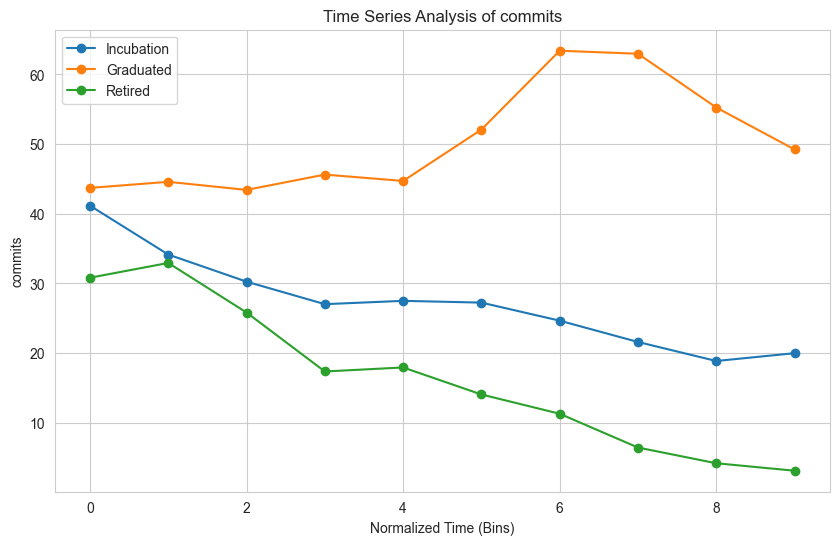

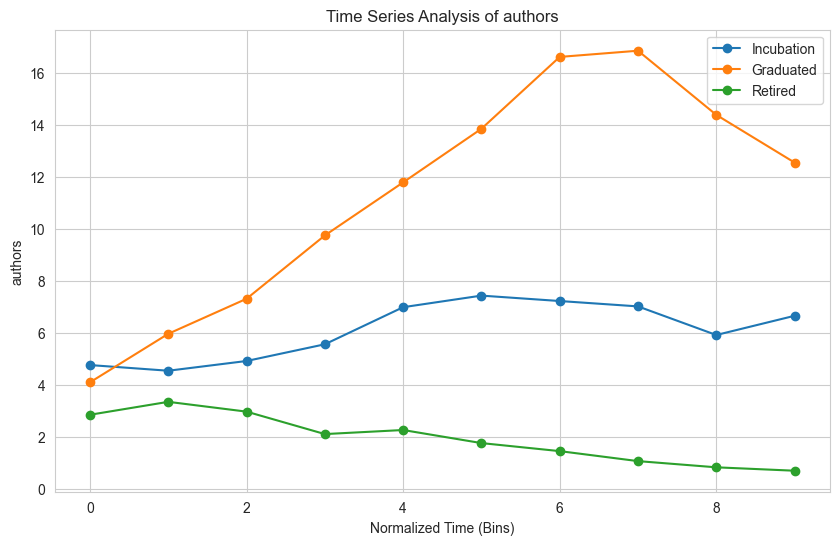

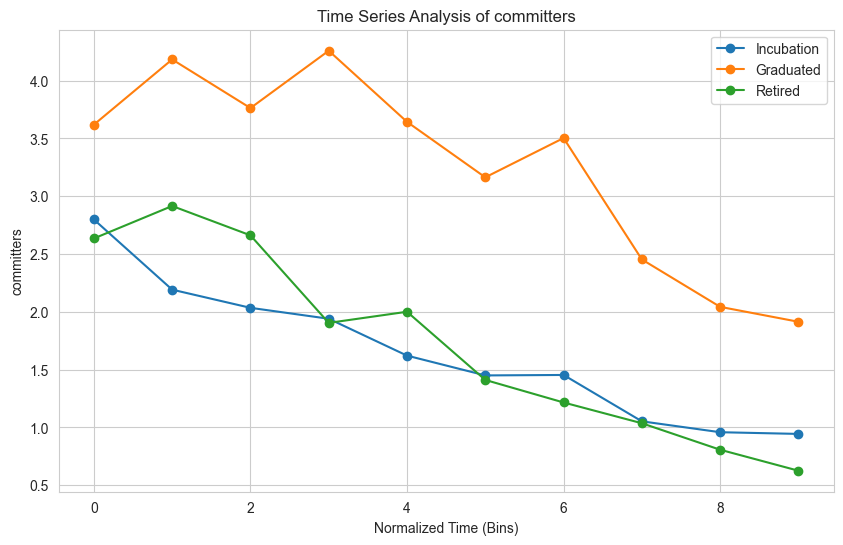

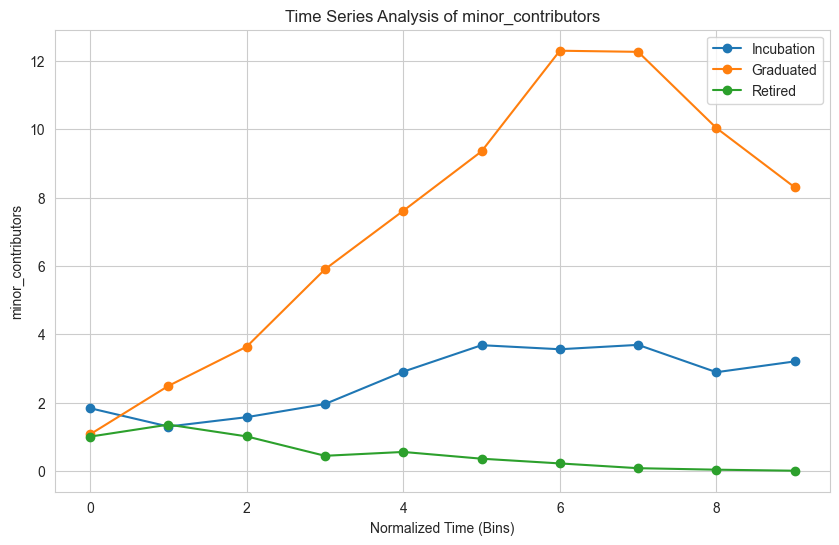

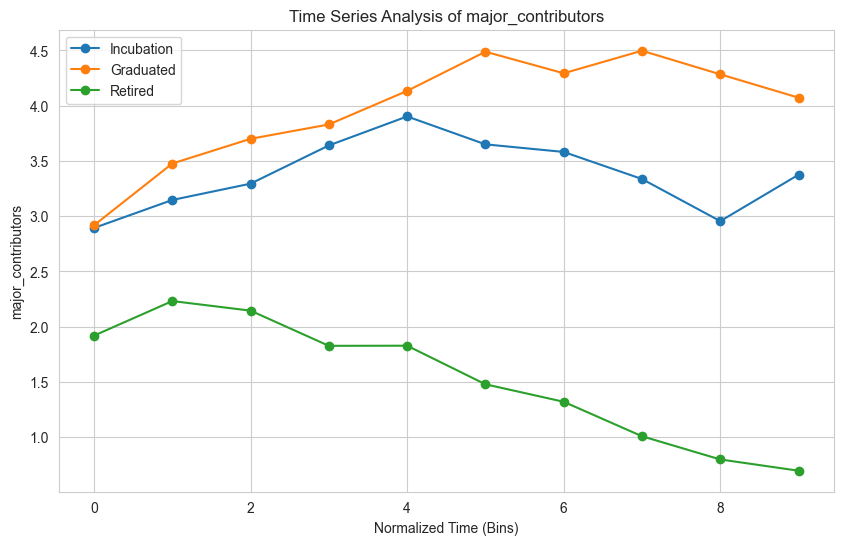

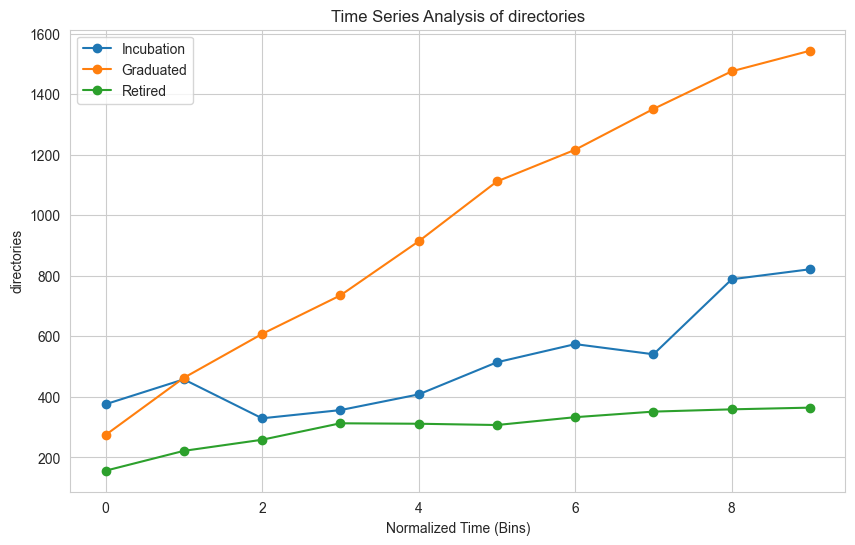

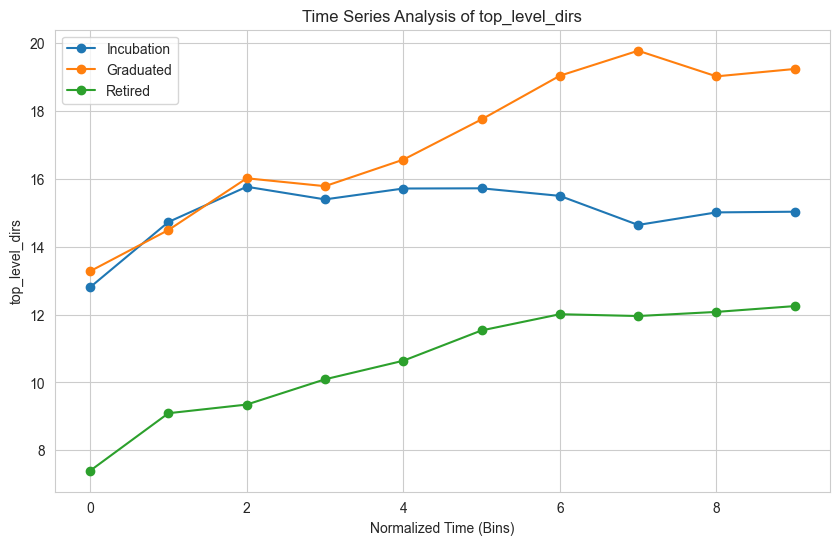

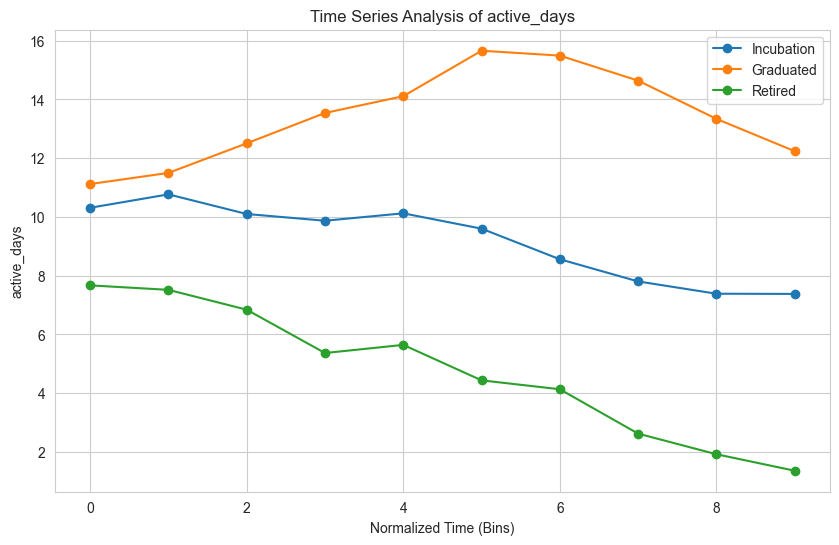

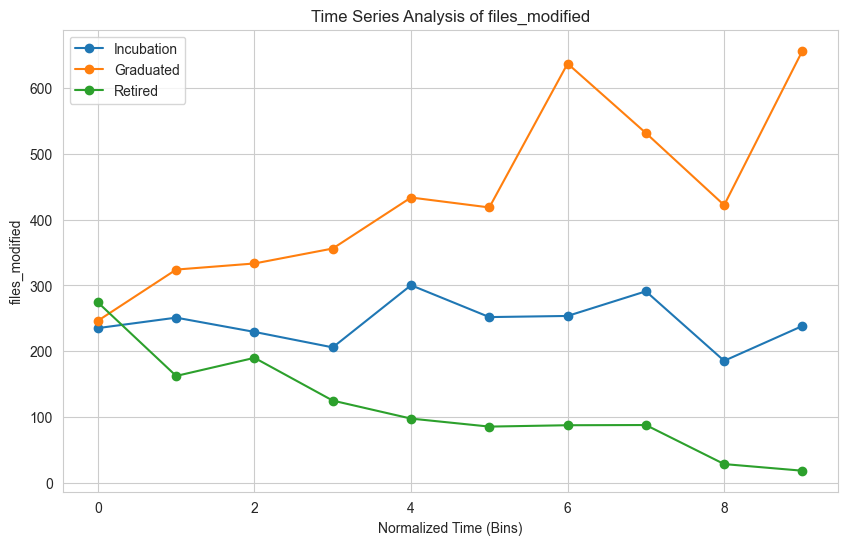

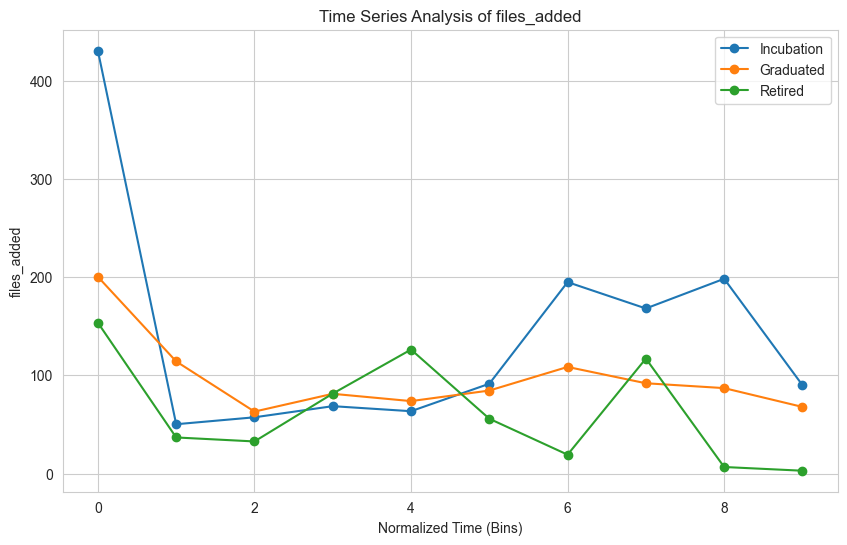

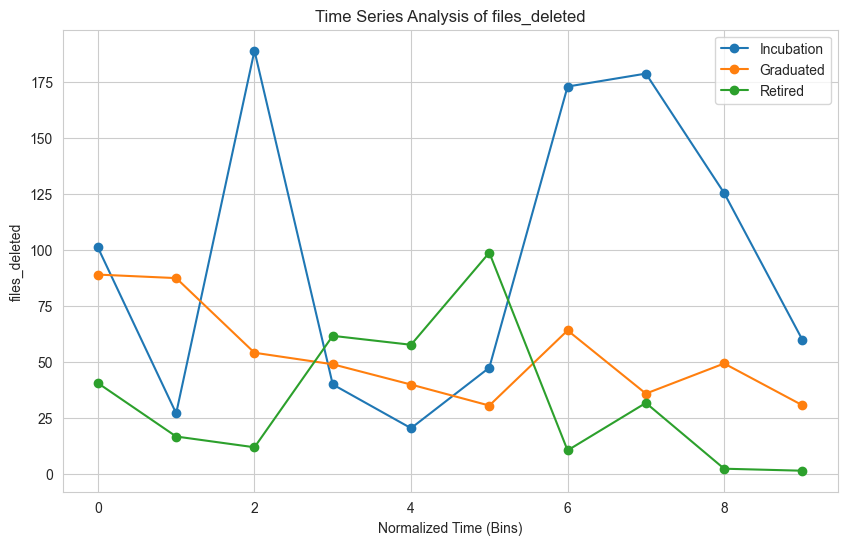

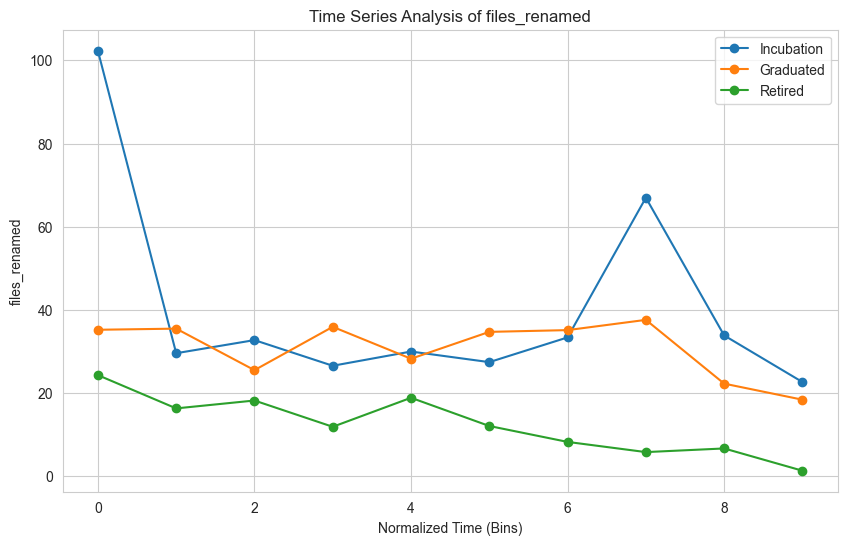

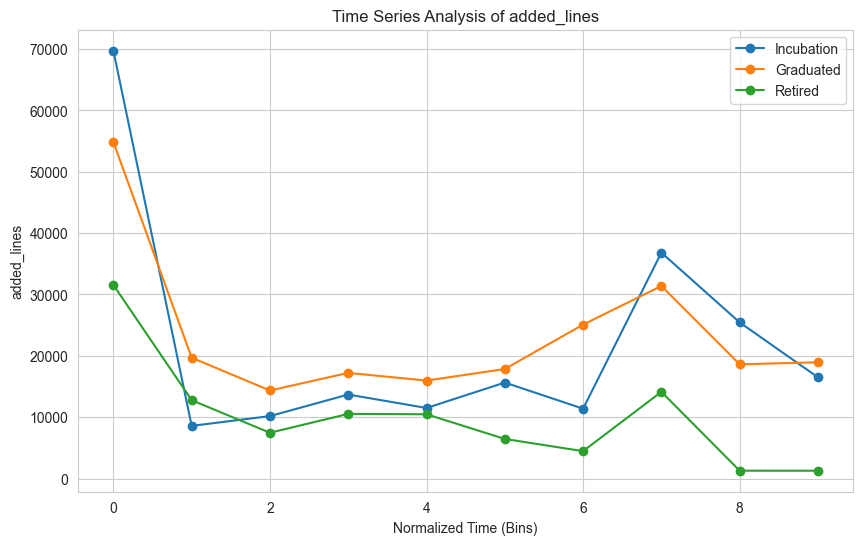

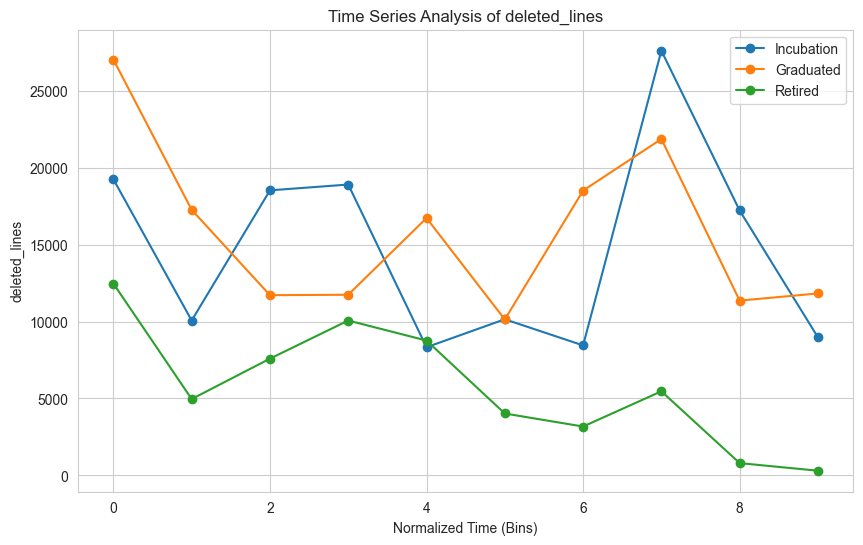

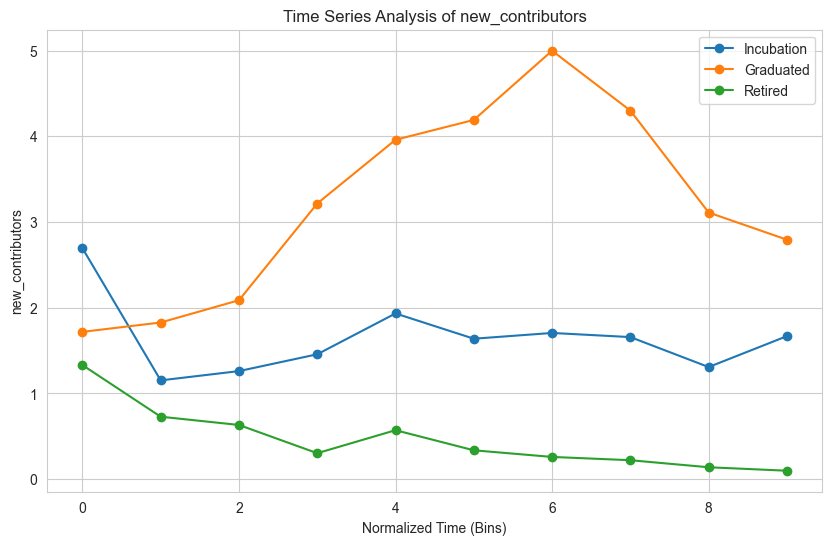

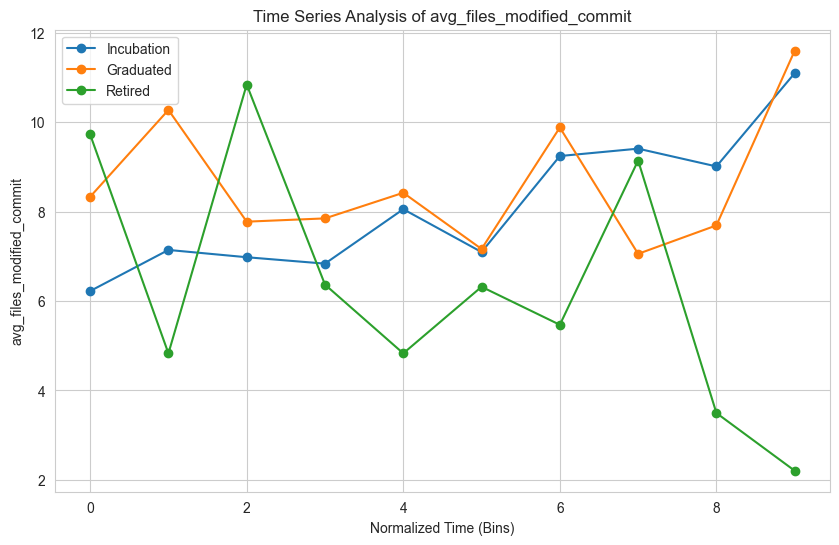

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project,
                df in cleaned_data.items() if len(df) >= 10}

# Filter status_data to only include projects present in cleaned_data
status_data_filtered = status_data[status_data['project'].isin(
    cleaned_data.keys())]


# Merge project status into each dataframe
def merge_status(cleaned_data, status_data):
  status_dict = status_data.set_index('project')['status'].to_dict()
  for project, df in cleaned_data.items():
    df['status'] = status_dict.get(project, 'Unknown')
  return cleaned_data

# Function to extract 1/10th segments and compute averages


def extract_average_feature(df, feature, num_bins=10):
  df = df.sort_values(by='measurement_month')  # Ensure time is sorted
  bin_size = max(1, len(df) // num_bins)  # Determine bin size
  averages = [df[feature].iloc[i *
                               bin_size: (i + 1) * bin_size].mean() for i in range(num_bins)]
  return averages

# Function to plot feature trends


def plot_feature(cleaned_data, status_data, feature, num_bins=10):
  cleaned_data = merge_status(cleaned_data, status_data)

  # Collect averaged data for each status
  grouped_data = {status: [[] for _ in range(
      num_bins)] for status in status_data['status'].unique()}
  for project, df in cleaned_data.items():
    if feature in df.columns:
      status = df['status'].iloc[0]
      averages = extract_average_feature(df, feature, num_bins)
      for i, avg in enumerate(averages):
        grouped_data[status][i].append(avg)

  # Compute overall average per bin for each status group
  plt.figure(figsize=(10, 6))
  for status, bins in grouped_data.items():
    avg_series = [
        np.mean(bin_values) if bin_values else 0 for bin_values in bins]
    plt.plot(range(num_bins), avg_series, marker='o', label=status)

  plt.xlabel('Normalized Time (Bins)')
  plt.ylabel(feature)
  plt.title(f'Time Series Analysis of {feature}')
  plt.legend()
  plt.show()

# Function to plot all features


def plot_all_features(cleaned_data, status_data, features, num_bins=10):
  for feature in features:
    plot_feature(cleaned_data, status_data, feature, num_bins)


# Example usage:
plot_all_features(cleaned_data, status_data, [
    'commits', 'authors', 'committers', 'minor_contributors', 'major_contributors',
    'directories', 'top_level_dirs', 'active_days', 'files_modified', 'files_added',
    'files_deleted', 'files_renamed', 'added_lines', 'deleted_lines', 'new_contributors',
    'avg_files_modified_commit'
])